# ORIE 5370 Final Project Mean-Variance and Maximum Diversification Section Code

In [17]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('D:\\Cornell\\Spring 2024\\ORIE 5370\\Project')

# Load the data
data = pd.read_excel('combined stock returns.xlsx', parse_dates=True)

# Data Preparation

In [18]:
data = data.sort_values(by='Date', ascending=True)
data.head()

,Date,AAPL_Return,AB_Return,DIS_Return,GOOG_Return,MSFT_Return,NVDA_Return,PYPL_Return,TSLA_Return,AAPL,AB,DIS,GOOG,MSFT,NVDA,PYPL,TSLA
0,2015-07-08,-0.024823,-0.015432,-0.016311,-0.015599,-0.001354,-0.007074,-0.052430,-0.048231,27.617405,13.559929,107.632240,25.841499,38.723919,4.757431,34.700001,16.997334
1,2015-07-09,-0.020396,0.000348,0.003559,0.007449,0.006329,-0.012214,-0.005764,0.011610,27.054110,13.564651,108.015335,26.034000,38.969006,4.699323,34.500000,17.194668
2,2015-07-10,0.026734,0.006616,0.007267,0.018149,0.002022,0.017517,0.005507,0.004769,27.777388,13.654389,108.800232,26.506500,39.047791,4.781640,34.689999,17.276667
3,2015-07-13,0.019305,-0.002421,0.013827,0.030973,0.020847,0.006582,0.060248,0.011615,28.313641,13.621328,110.304596,27.327499,39.861828,4.813115,36.779999,17.477333
4,2015-07-14,-0.000398,-0.021151,-0.001694,0.026622,0.001757,0.000503,0.004078,0.013312,28.302372,13.333221,110.117714,28.055000,39.931854,4.815536,36.930000,17.709999


In [19]:
data.drop(columns=['AAPL', 'AB', 'DIS', 'GOOG', 'MSFT', 'NVDA', 'PYPL', 'TSLA'], inplace = True)
data.head()

,Date,AAPL_Return,AB_Return,DIS_Return,GOOG_Return,MSFT_Return,NVDA_Return,PYPL_Return,TSLA_Return
0,2015-07-08,-0.024823,-0.015432,-0.016311,-0.015599,-0.001354,-0.007074,-0.052430,-0.048231
1,2015-07-09,-0.020396,0.000348,0.003559,0.007449,0.006329,-0.012214,-0.005764,0.011610
2,2015-07-10,0.026734,0.006616,0.007267,0.018149,0.002022,0.017517,0.005507,0.004769
3,2015-07-13,0.019305,-0.002421,0.013827,0.030973,0.020847,0.006582,0.060248,0.011615
4,2015-07-14,-0.000398,-0.021151,-0.001694,0.026622,0.001757,0.000503,0.004078,0.013312


In [20]:
data.columns = ['Date', 'AAPL', 'AB', 'DIS', 'GOOG', 'MSFT', 'NVDA', 'PYPL', 'TSLA']
data.head()

,Date,AAPL,AB,DIS,GOOG,MSFT,NVDA,PYPL,TSLA
0,2015-07-08,-0.024823,-0.015432,-0.016311,-0.015599,-0.001354,-0.007074,-0.052430,-0.048231
1,2015-07-09,-0.020396,0.000348,0.003559,0.007449,0.006329,-0.012214,-0.005764,0.011610
2,2015-07-10,0.026734,0.006616,0.007267,0.018149,0.002022,0.017517,0.005507,0.004769
3,2015-07-13,0.019305,-0.002421,0.013827,0.030973,0.020847,0.006582,0.060248,0.011615
4,2015-07-14,-0.000398,-0.021151,-0.001694,0.026622,0.001757,0.000503,0.004078,0.013312


In [21]:
data.isna().sum()

Date    0
AAPL    0
AB      0
DIS     0
GOOG    0
MSFT    0
NVDA    0
PYPL    0
TSLA    0
dtype: int64

In [22]:
data['Date'] = pd.to_datetime(data['Date'])  # Ensure 'Date' is datetime type
data.set_index('Date', inplace=True)
returns = data

In [23]:
returns.head()

,AAPL,AB,DIS,GOOG,MSFT,NVDA,PYPL,TSLA
Date,,,,,,,,
2015-07-08,-0.024823,-0.015432,-0.016311,-0.015599,-0.001354,-0.007074,-0.052430,-0.048231
2015-07-09,-0.020396,0.000348,0.003559,0.007449,0.006329,-0.012214,-0.005764,0.011610
2015-07-10,0.026734,0.006616,0.007267,0.018149,0.002022,0.017517,0.005507,0.004769
2015-07-13,0.019305,-0.002421,0.013827,0.030973,0.020847,0.006582,0.060248,0.011615
2015-07-14,-0.000398,-0.021151,-0.001694,0.026622,0.001757,0.000503,0.004078,0.013312


In [24]:
symbols = returns.columns.tolist()

# Function to calculate compound returns
def compound_return(returns):
    return np.prod(1 + returns) - 1

def additive_return(returns):
    return np.mean(returns) * 20 # 20-day rebalancing period

# Number of stocks
n = len(symbols)

# Initialize lists to store results
optimal_weights_mv = []
expected_returns_mv = []
expected_risks_mv = []
period_returns_mv = []
dates_mv = []

# portfolio setting
initial_value = 100000
portfolio_value_mv = [initial_value]

# 1. Min Variance

## 1.2 Covariance Matrix - Within Rebalancing Period + Compound Return

In [25]:
optimal_weights_mv = []
expected_returns_mv = []
expected_risks_mv = []
period_returns_mv = []
dates_mv = []

# portfolio setting
initial_value = 100000
portfolio_value_mv = [initial_value]

In [26]:
for i in range(0, len(returns) - 40, 20):  # Loop starts from 0, ensures 20 days ahead available
    R = returns.iloc[i:i+20]  # Returns used for weight calculation
    next_R = returns.iloc[i+20:i+40]  # Returns for the next period to apply weights
    
    if len(R) < 20 or len(next_R) < 20:  # Skip if insufficient data
        break

    comp_return = R.apply(compound_return, axis=0).values
    comp_return = comp_return.reshape(-1, 1)
    past = returns.iloc[:i + 20]
    C = np.cov(R.T)

    # Optimization variables for long and short positions
    x_mv = cp.Variable(len(R.columns), nonneg=True)
    ret = comp_return.T @ x_mv
    risk = cp.quad_form(x_mv, C)
    
    constraints = [
        cp.sum(x_mv) == 1,
        x_mv <= 0.2,
        x_mv >= 0,
        ret >= 0.02
    ]
    
    prob = cp.Problem(cp.Minimize(risk), constraints)
    
    try:
        prob.solve()
        if x_mv.value is not None and np.isfinite(x_mv.value).all() and prob.status != 'infeasible':
            # If new weights are valid
            optimal_weights_mv.append(x_mv.value)
            expected_returns_mv.append(ret.value)
            expected_risks_mv.append(np.sqrt(risk.value))
            dates_mv.append(R.index[-1])
            # Calculate the period return with new weights
            weights = x_mv.value
            weighted_returns = next_R.multiply(weights, axis='columns')
            compound_portfolio_return = ((1 + weighted_returns).prod() - 1).sum()
            period_returns_mv.append(compound_portfolio_return)
            # Determine new portfolio value
            if i == 0 or (optimal_weights_mv[-2] == np.zeros(len(symbols))).all():
                # If first iteration or last weights were zero
                new_value = portfolio_value_mv[-1]  # No change if last weights were zero
            else:
                new_value = portfolio_value_mv[-1] * (1 + period_returns_mv[-2])
            # print(dates_mv[-1], new_value)
        else:
            # Hold cash if no valid weights are found
            optimal_weights_mv.append(np.zeros(len(symbols)))
            period_returns_mv.append(0.02)
            dates_mv.append(R.index[-1])
            if i == 0 or (optimal_weights_mv[-2] == np.zeros(len(symbols))).all():
                new_value = portfolio_value_mv[-1]
            else:
                new_value = portfolio_value_mv[-1] * (1 + period_returns_mv[-2])
            # print(dates_mv[-1], new_value)  

    except Exception as e:
        print(f"Error during period ending {R.index[-1]}: {str(e)}")
        new_value = portfolio_value_mv[-1]  # Hold cash in case of optimization error
        optimal_weights_mv.append(None)
        expected_returns_mv.append(None)
        expected_risks_mv.append(None)
        dates_mv.append(R.index[-1])
        # print(dates_mv[-1], new_value)
    
    if i == 0:
        continue
    else:
        portfolio_value_mv.append(new_value)

print(portfolio_value_mv[-1])
    # if i == 0:
    #     print(R.index[-1], new_value, optimal_weights[-1])
    #     continue
    # else:
    #     
    # print(R.index[-1], new_value, optimal_weights[-1])

366519.5298302075


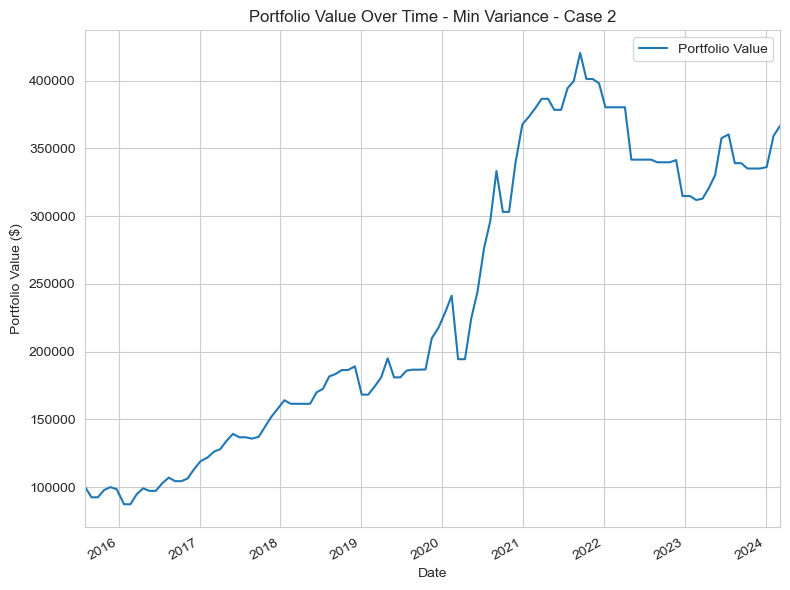

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(dates_mv, portfolio_value_mv, label='Portfolio Value')

# Assuming 'dates' is sorted, set the x-axis limits to the first and last date in your 'dates' list
plt.xlim(dates_mv[0], dates_mv[-1])

plt.title('Portfolio Value Over Time - Min Variance - Case 2')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.xticks(rotation=45)
# This ensures that the x-axis ticks are nicely formatted as dates
plt.gcf().autofmt_xdate()  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


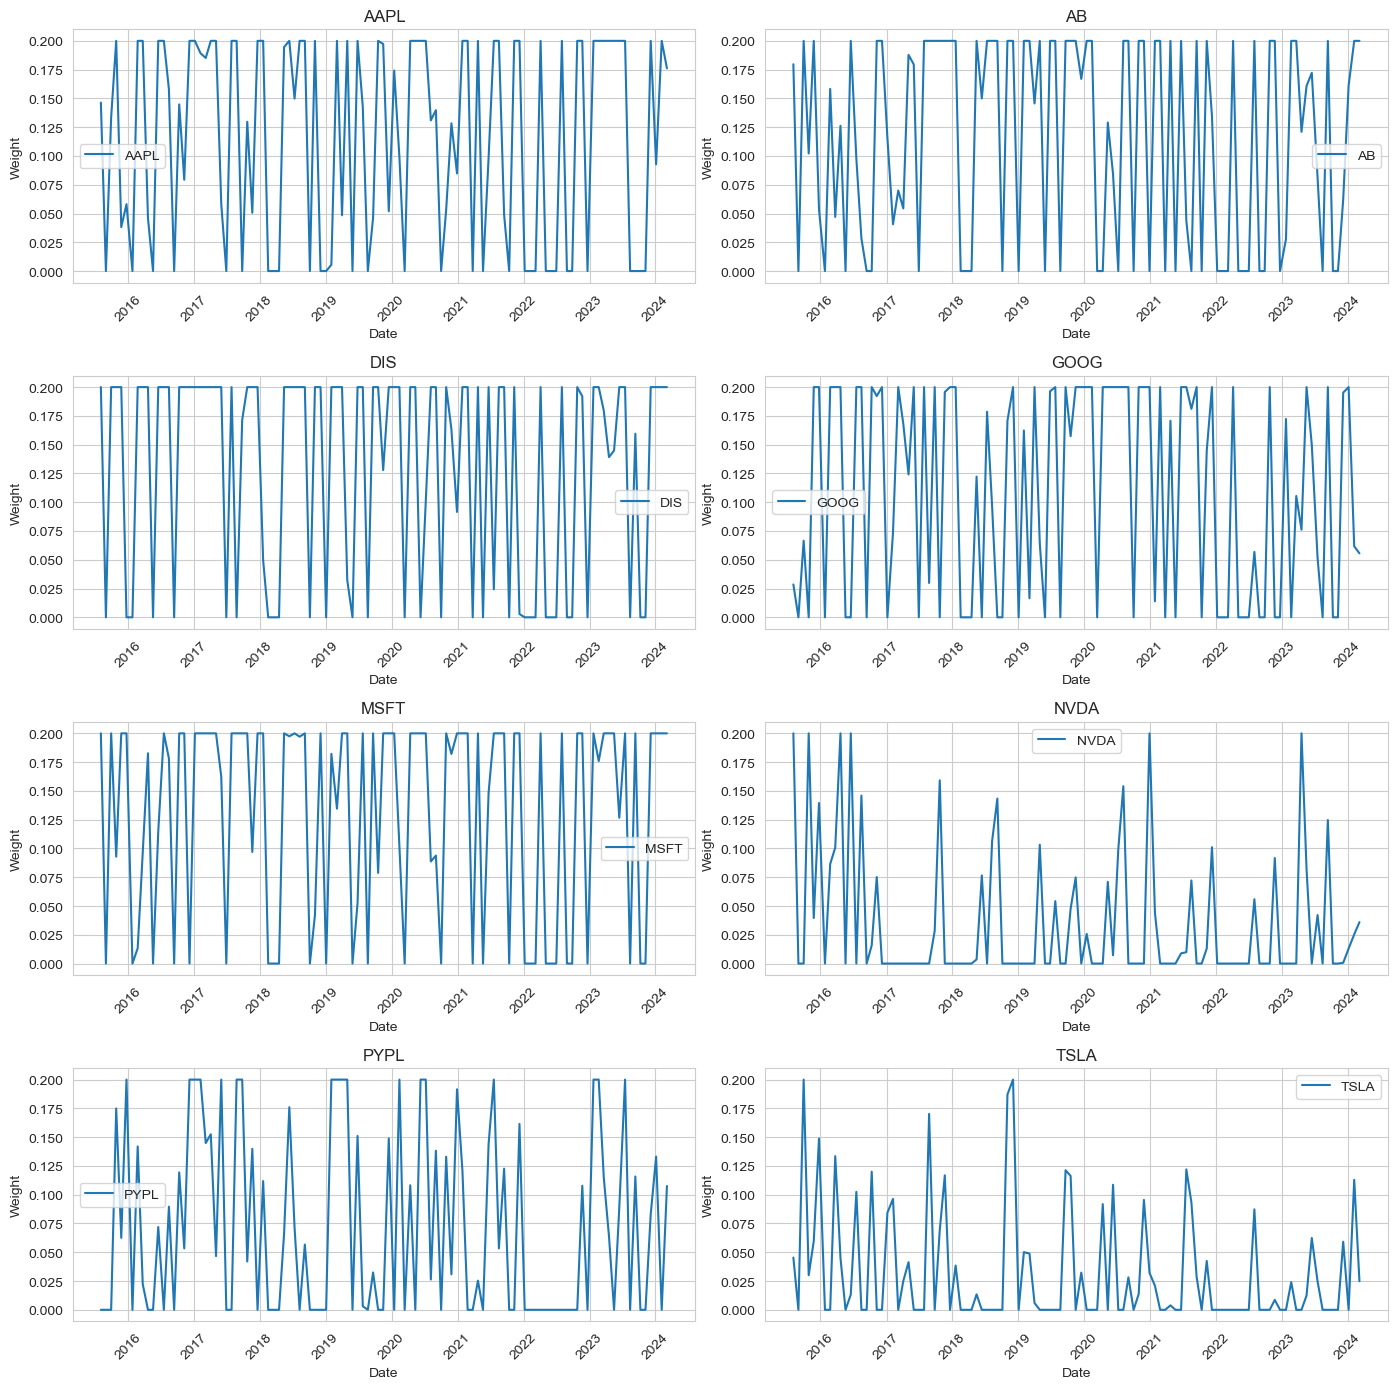

In [28]:
sns.set_style("whitegrid")

# Make sure optimal_weights is not empty
if optimal_weights_mv:
    weights_df = pd.DataFrame(optimal_weights_mv, columns=symbols, index=dates_mv)
    
    # Number of rows and columns for the subplot grid
    # We'll create a 4x2 grid to display the 8 stocks
    num_rows = 4
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))  # Adjust the figure size as needed
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each stock's weights on its own subplot
    for i, column in enumerate(weights_df.columns):
        ax = axes[i]
        sns.lineplot(data=weights_df, x=weights_df.index, y=column, ax=ax)
        ax.set_title(column)
        ax.set_xlabel('Date')
        ax.set_ylabel('Weight')
        # Set legend for each subplot if desired
        ax.legend([column])
        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(45)
    
    # Adjust the layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

else:
    print("No weights data available to plot.")


# 2. Max Diversification

## 2.2 Convariance Matrix - All History

In [29]:
optimal_weights_md = []
expected_risks_md = []
period_returns_md = []
dates_md = []

portfolio_value_md = [initial_value]

for i in range(0, len(returns) - 40, 20):  # Ensures 20 days ahead available
    R = returns.iloc[i:i+20]  # Returns used for weight calculation
    next_R = returns.iloc[i+20:i+40]  # Returns for the next period to apply weights

    if len(R) < 20 or len(next_R) < 20:  # Skip if insufficient data
        break

    past = returns.iloc[:i+20]
    C = np.cov(past.T)
    volatilities = np.sqrt(np.diag(C))

    # Optimization variables for maximum diversification
    y_md = cp.Variable(n, nonneg=True)
    Sigma_md = volatilities  # Sigma vector for asset volatilities

    transformed_md = cp.quad_form(y_md, C)

    # Optimization problem
    constraints_md = [
        cp.sum(cp.multiply(Sigma_md, y_md)) == 1,
        y_md >= 0
    ]
    prob_md = cp.Problem(cp.Minimize(transformed_md), constraints_md)


    try:
        prob_md.solve(qcp=True)
        if y_md.value is not None and np.isfinite(y_md.value).all() and prob.status != 'infeasible':
            # If new weights are valid
            x_md = y_md.value / np.sum(y_md.value)
            optimal_weights_md.append(x_md)
            expected_risks_md.append(np.sqrt(np.sqrt(np.dot(x_md.T, np.dot(C, x_md)))))

            dates_md.append(R.index[-1])
            # Calculate the period return with new weights
            weights = x_md
            weighted_returns = next_R.multiply(weights, axis='columns')
            compound_portfolio_return_md = ((1 + weighted_returns).prod() - 1).sum()
            period_returns_md.append(compound_portfolio_return_md)
            # Determine new portfolio value
            if i == 0 or (optimal_weights_md[-2] == np.zeros(len(symbols))).all():
                # If first iteration or last weights were zero
                new_value = portfolio_value_md[-1]  # No change if last weights were zero
            else:
                new_value = portfolio_value_md[-1] * (1 + period_returns_md[-2])
        else:
            # Hold cash if no valid weights are found
            optimal_weights_md.append(np.zeros(len(symbols)))
            period_returns_md.append(0)
            dates_md.append(R.index[-1])
            if i == 0 or (optimal_weights_md[-2] == np.zeros(len(symbols))).all():
                new_value = portfolio_value_md[-1]
            else:
                new_value = portfolio_value_md[-1] * (1 + period_returns_md[-2])

    except Exception as e:
        print(f"Error during period ending {R.index[-1]}: {str(e)}")
        new_value = portfolio_value_md[-1]  # Hold cash in case of optimization error
        optimal_weights_md.append(None)
        expected_risks_md.append(None)
        dates_md.append(R.index[-1])
    
    if i == 0:
        continue
    else:
        portfolio_value_md.append(new_value)
    
print(portfolio_value_md[-1])

701607.7787177782


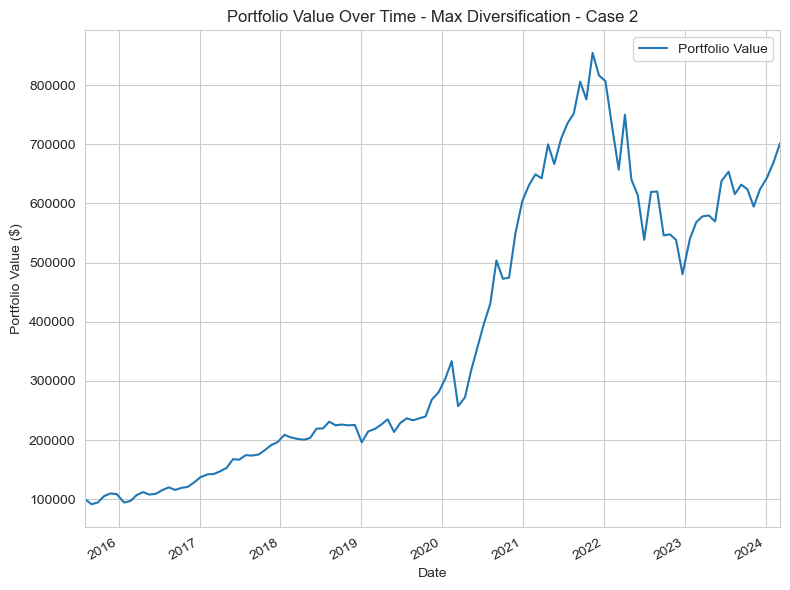

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(dates_md, portfolio_value_md, label='Portfolio Value')

# Assuming 'dates' is sorted, set the x-axis limits to the first and last date in your 'dates' list
plt.xlim(dates_md[0], dates_md[-1])

plt.title('Portfolio Value Over Time - Max Diversification - Case 2')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.xticks(rotation=45)
# This ensures that the x-axis ticks are nicely formatted as dates
plt.gcf().autofmt_xdate()  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


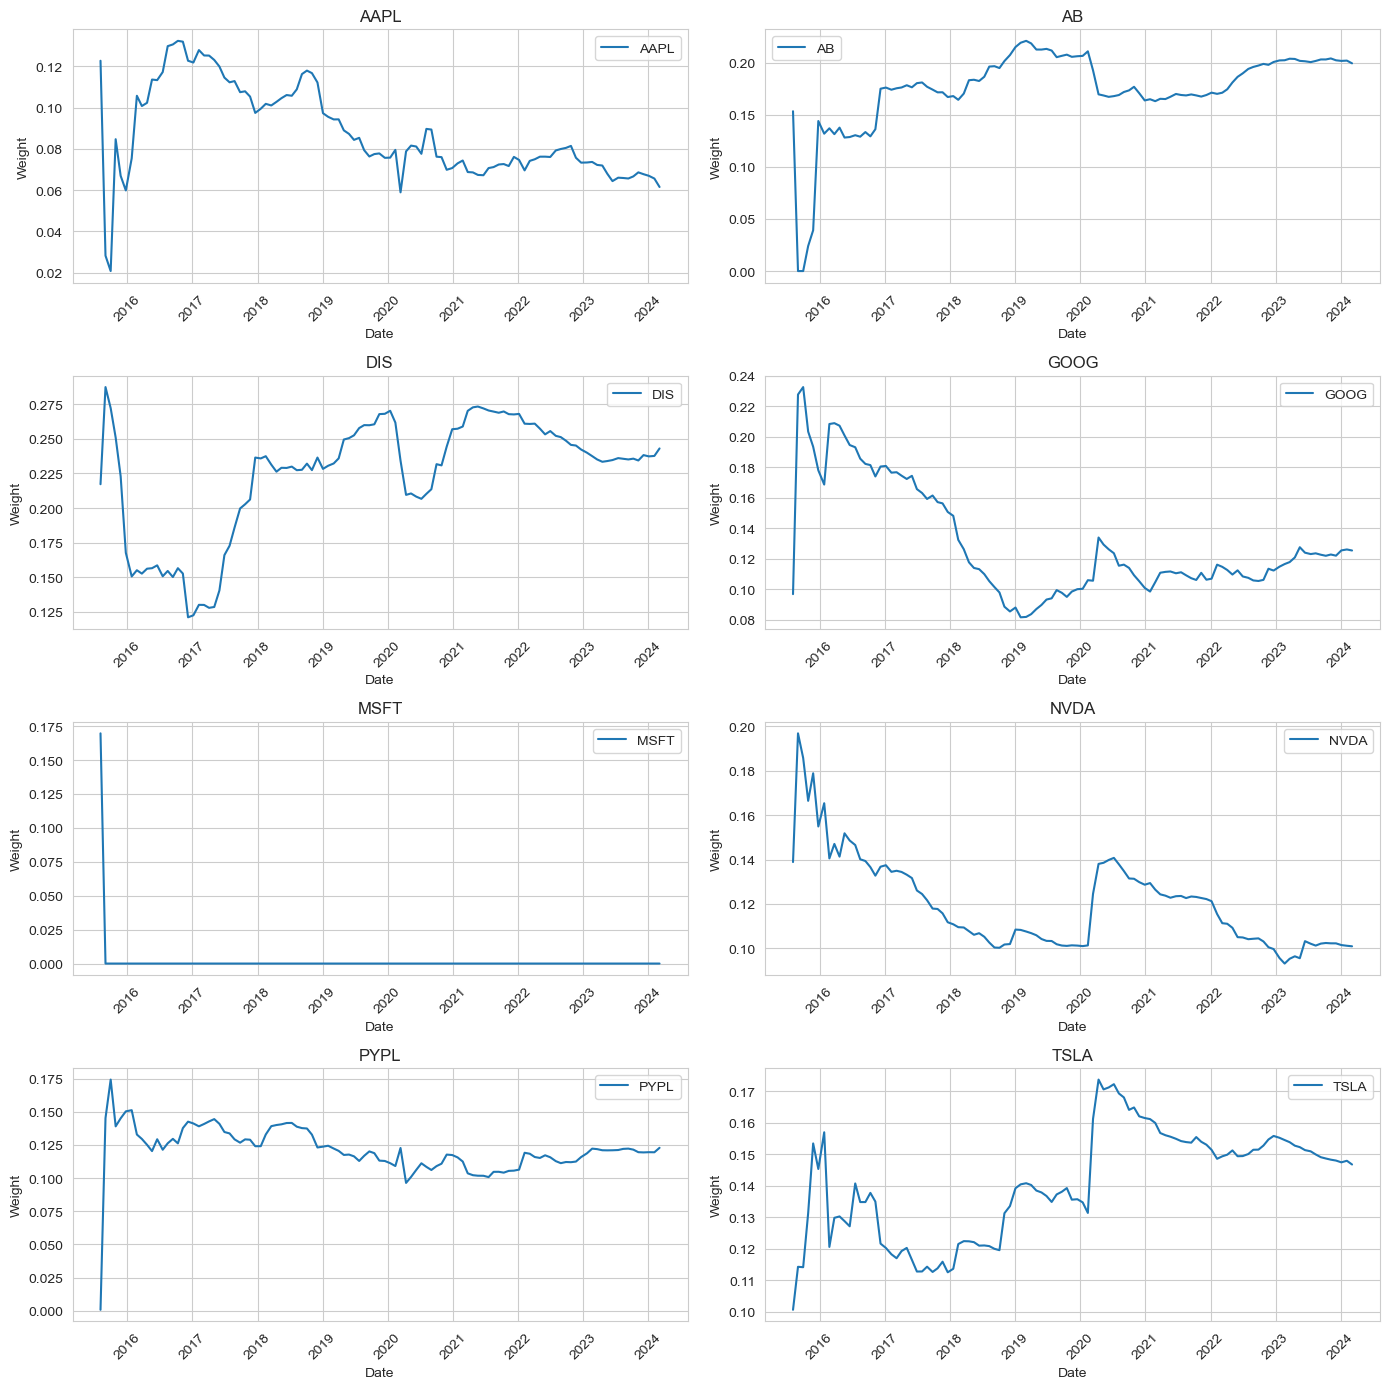

In [31]:
sns.set_style("whitegrid")

# Make sure optimal_weights is not empty
if optimal_weights_md:
    weights_df = pd.DataFrame(optimal_weights_md, columns=symbols, index=dates_md)
    
    # Number of rows and columns for the subplot grid
    # We'll create a 4x2 grid to display the 8 stocks
    num_rows = 4
    num_cols = 2
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))  # Adjust the figure size as needed
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each stock's weights on its own subplot
    for i, column in enumerate(weights_df.columns):
        ax = axes[i]
        sns.lineplot(data=weights_df, x=weights_df.index, y=column, ax=ax)
        ax.set_title(column)
        ax.set_xlabel('Date')
        ax.set_ylabel('Weight')
        # Set legend for each subplot if desired
        ax.legend([column])
        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(45)
    
    # Adjust the layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

else:
    print("No weights data available to plot.")
